# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md). This notebook includes only what's necessary to run in Colab.

### Install

In [1]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

Make sure you have `pycocotools` installed

In [2]:
!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [1]:
import os
import pathlib


#if "models" in pathlib.Path.cwd().parts:
 # while "models" in pathlib.Path.cwd().parts:
  #  os.chdir('..')
#elif not pathlib.Path('models').exists():
#  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [2]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [5]:
%%bash 
cd models/research
pip install .

Processing /Users/zhaowenpei/Desktop/new_model/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1661658 sha256=980a4bf94bcad9e399adf7d009a3c5c99aca5d6edb73c76b19f63a823993410b
  Stored in directory: /private/var/folders/hb/1dpkwy2d0hlgfdwzrd1htjgr0000gn/T/pip-ephem-wheel-cache-zr613wme/wheels/bc/68/ba/ad5ded888d67e5f7b857bce06fba2dbe08ee6ac41992b0f271
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


### Imports

In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [4]:
import os 
os.sys.executable

'/Users/zhaowenpei/opt/miniconda3/envs/tensorflow/bin/python'

Import the object detection module.

In [4]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [5]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [6]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
  model_file = 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = "/Users/zhaowenpei/Desktop/new_model/saved_model"

  detection_model = load_model(model_name)

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

For the sake of simplicity we will test on 2 images:

In [7]:
#import pathlib
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/Users/zhaowenpei/Desktop/new_model/data/annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/Users/zhaowenpei/Desktop/new_model/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

model_dir = "/Users/zhaowenpei/Desktop/new_model/saved_model"

detection_model = tf.saved_model.load(str(model_dir))

2022-07-25 09:58:01.548956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Detection

Load an object detection model:

In [21]:
#model_name = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'
#detection_model = load_model(model_name)

Check the model's input signature, it expects a batch of 3-color images of type uint8:

In [8]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=resource>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=resource>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' shape=() dtype=resource>, <tf.Tensor 'unknown_9:0' shape=() dtype=resource>, <tf.Tensor 'unknown_10:0' shape=() dtype=resource>, <tf.Tensor 'unknown_11:0' shape=() dtype=resource>, <tf.Tensor 'unknown_12:0' shape=() dtype=resource>, <tf.Tensor 'unknown_13:0' shape=() dtype=resource>, <tf.Tensor 'unknown_14:0' shape=() dtype=resource>, <tf.Tensor 'unknown_15:0' shape=() dtype=resource>, <tf.Tensor 'unknown_16:0' shape=() dtype=resource>, <tf.Tenso

And returns several outputs:

In [9]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_anchor_indices': tf.float32,
 'raw_detection_boxes': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_multiclass_scores': tf.float32}

In [10]:
detection_model.signatures['serving_default'].output_shapes

{'detection_anchor_indices': TensorShape([1, 100]),
 'raw_detection_boxes': TensorShape([1, 1917, 4]),
 'raw_detection_scores': TensorShape([1, 1917, 6]),
 'detection_scores': TensorShape([1, 100]),
 'num_detections': TensorShape([1]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'detection_classes': TensorShape([1, 100]),
 'detection_multiclass_scores': TensorShape([1, 100, 6])}

Add a wrapper function to call the model, and cleanup the outputs:

In [11]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [12]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

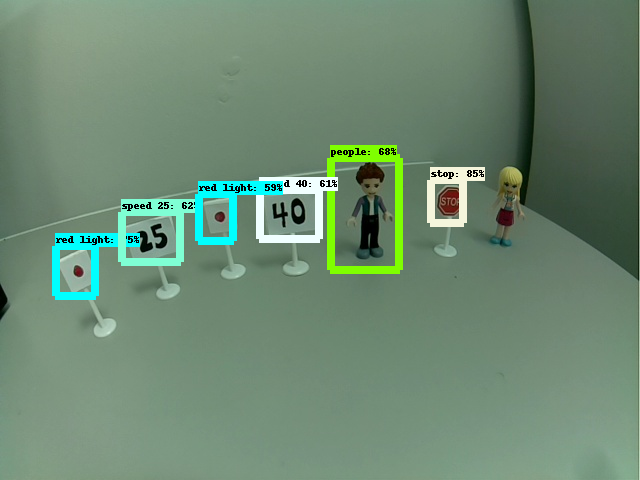

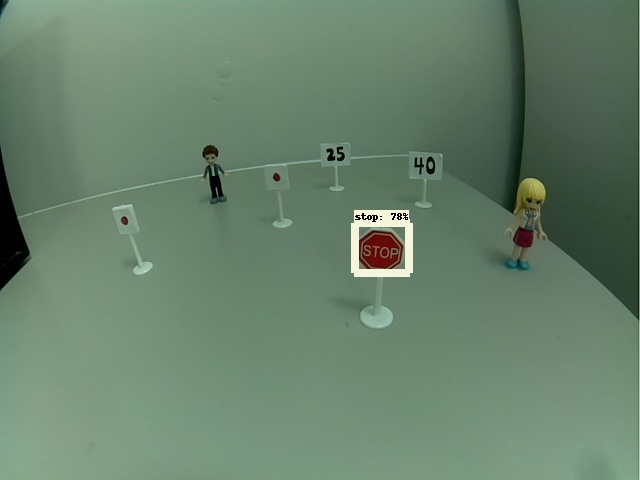

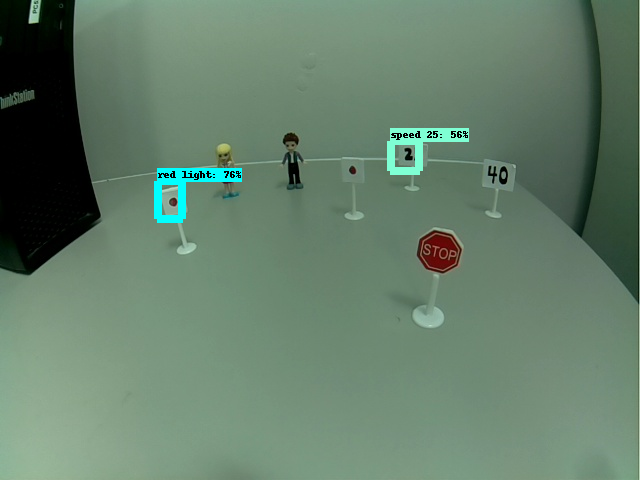

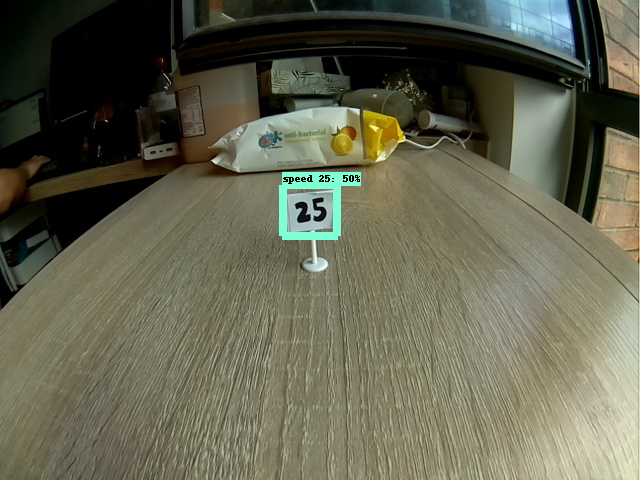

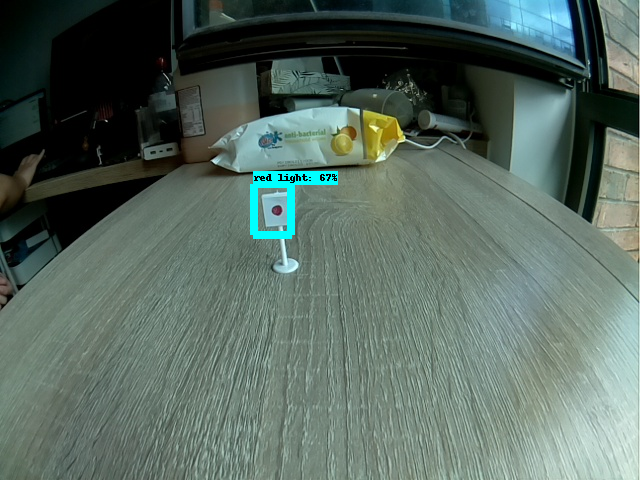

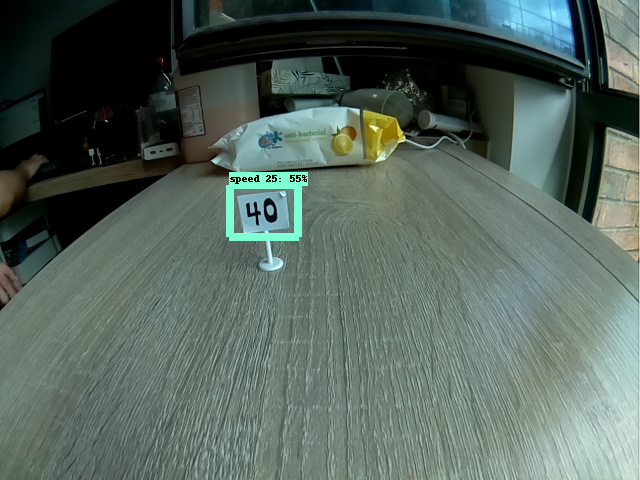

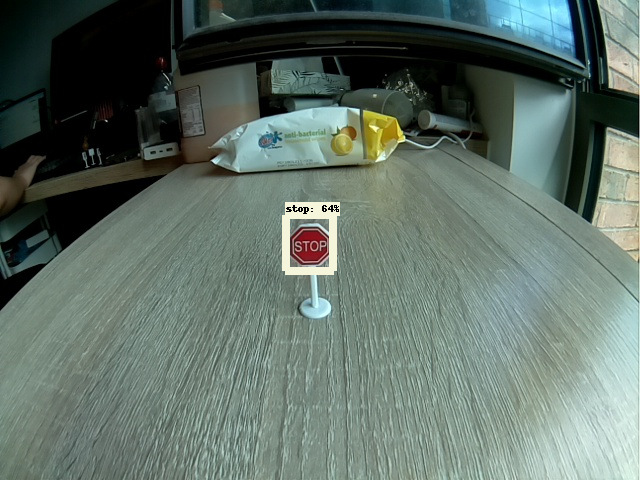

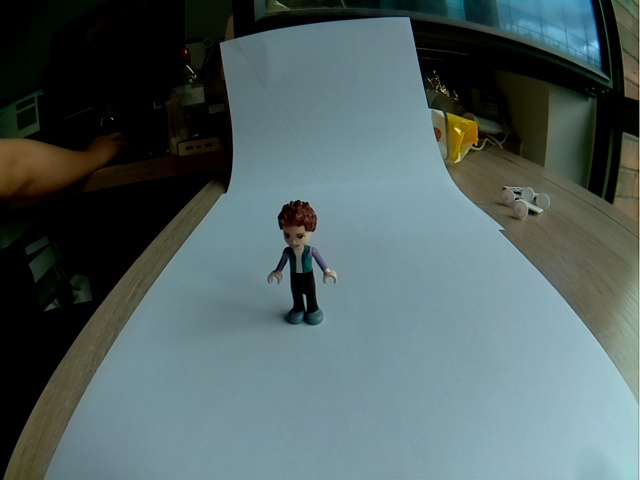

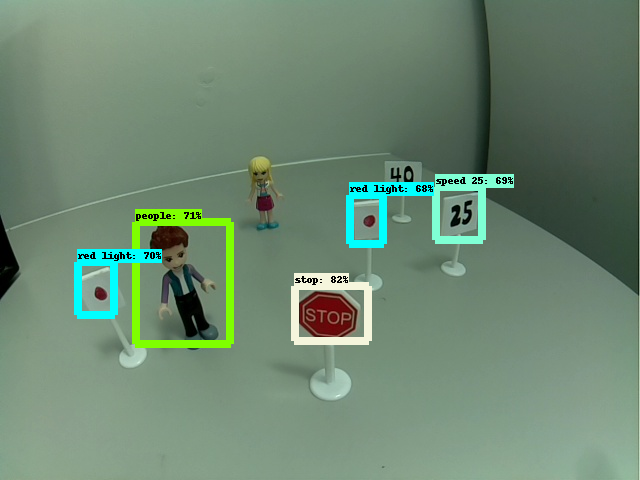

In [13]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


## Instance Segmentation

In [ ]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

The instance segmentation model includes a `detection_masks` output:

In [ ]:
masking_model.output_shapes

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)

In [ ]:
!pip install utils

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!sudo pip3 install tf_slim
!sudo pip3 install tensorflow_io
!pip install tf-models-official

!python object_detection/builders/model_builder_test.py

In [ ]:
%cd /content/models/research/

!python setup.py install

In [ ]:
%cd /content/drive/MyDrive/pretrained_model/

!python3 testpic.py